/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saving 22.jpeg to 22 (1).jpeg


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/tmp/ipython-input-3217851146.py:127: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap, 0)


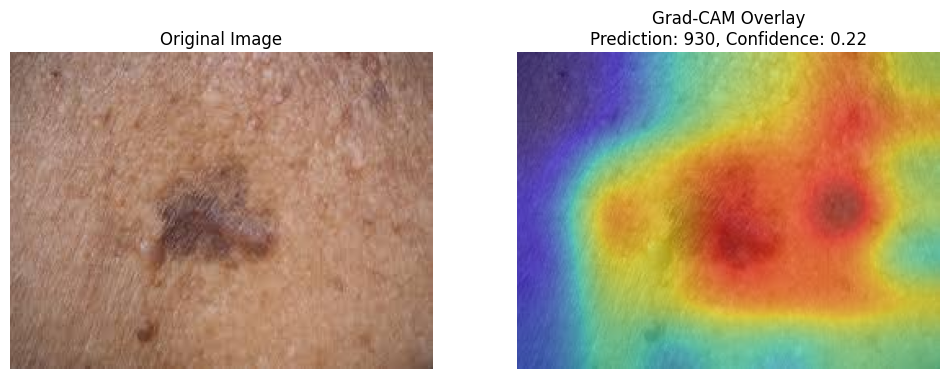

Prediction Class Index: 930
Confidence: 0.2235
Doctor Decision (accept/reject): reject
Reason (optional): 
Ground Truth (e.g., biopsy result): true
[LOG: Block 1 added] (Immutable Record)
✅ Logged entry with immutable hash! Blockchain Validity: All Records are Secure and Untouched


/tmp/ipython-input-3217851146.py:157: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  record_str = f"{filename}{pred_idx}{conf.item()}{doctor_decision}{doctor_reason}{ground_truth}{datetime.utcnow()}"
/tmp/ipython-input-3217851146.py:167: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S'),
/tmp/ipython-input-3217851146.py:60: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.timestamp = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')


,filename,prediction,confidence,doctor_decision,doctor_reason,ground_truth,timestamp,hash
0,22.jpeg,930,0.223453,accept,NaN,perfect,2025-10-17 09:10:26,9d2566bd939752baec05c51245189352558f554a415fdf...
1,22 (1).jpeg,930,0.223453,reject,,true,2025-10-17 09:28:49,8272da799dcfcbc5d7c00b63ac4f9ecedde2b6053b1fc2...


In [ ]:
 # 🧰 STEP 0: Install Dependencies
!pip install torch torchvision pillow matplotlib pandas

# 🧠 STEP 1: Import Libraries
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import hashlib
import json
import time
from datetime import datetime
from typing import Dict, Any, List, Tuple

# 📁 STEP 2: Create folders and CSV log file
os.makedirs('uploads', exist_ok=True)
LOG_FILE = 'bcf_accountability_log.csv'

if not os.path.exists(LOG_FILE):
    df = pd.DataFrame(columns=[
        'filename','prediction','confidence','doctor_decision',
        'doctor_reason','ground_truth','timestamp','hash'
    ])
    df.to_csv(LOG_FILE, index=False)

# 🔥 STEP 3: Load pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

features, gradients = None, None

def forward_hook(module, input, output):
    global features
    features = output.detach()

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

last_conv_layer = model.layer4[-1].conv3
last_conv_layer.register_forward_hook(forward_hook)
last_conv_layer.register_backward_hook(backward_hook)

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- 4. Blockchain / Immutable Ledger Classes ---
class Block:
    def __init__(self, index: int, data: Dict[str, Any], previous_hash: str):
        self.index = index
        self.timestamp = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
        self.data = data
        self.previous_hash = previous_hash
        self.hash = self.compute_hash()

    def compute_hash(self):
        block_string = json.dumps({
            "index": self.index,
            "timestamp": self.timestamp,
            "data": self.data,
            "previous_hash": self.previous_hash
        }, sort_keys=True)
        return hashlib.sha256(block_string.encode()).hexdigest()

class Blockchain:
    def __init__(self):
        self.chain: List[Block] = []
        self.create_genesis_block()

    def create_genesis_block(self):
        self.chain.append(Block(0, {"note": "Genesis Block - AI Accountability System Started"}, "0"))

    @property
    def last_block(self):
        return self.chain[-1]

    def add_log_entry(self, log_data: Dict[str, Any]):
        new_block = Block(
            index=self.last_block.index + 1,
            data=log_data,
            previous_hash=self.last_block.hash
        )
        self.chain.append(new_block)
        print(f"[LOG: Block {new_block.index} added] (Immutable Record)")
        return new_block

    def is_chain_valid(self):
        for i in range(1, len(self.chain)):
            current = self.chain[i]
            previous = self.chain[i-1]
            if current.hash != current.compute_hash():
                return False, f"Record Tampered at Block {current.index}"
            if current.previous_hash != previous.hash:
                return False, f"Link Broken at Block {current.index}"
        return True, "All Records are Secure and Untouched"

# --- 5. Upload image & prediction ---
uploaded = files.upload()
filename = list(uploaded.keys())[0]
img_path = os.path.join('uploads', filename)
Image.open(filename).save(img_path)

img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0)

output = model(input_tensor)
probs = F.softmax(output, dim=1)
conf, pred = torch.max(probs, dim=1)
pred_idx = pred.item()

model.zero_grad()
output[0, pred_idx].backward(retain_graph=True)

pooled_grads = torch.mean(gradients, dim=[0,2,3])
for i in range(features.shape[1]):
    features[0,i,:,:] *= pooled_grads[i]
heatmap = torch.mean(features[0], dim=0).cpu()
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
heatmap = np.uint8(255 * heatmap.numpy())

heatmap = Image.fromarray(heatmap).resize(img.size)
heatmap_np = np.array(heatmap)
cmap = plt.get_cmap('jet')
colored = np.uint8(255 * cmap(heatmap_np/255.0)[:,:,:3])
overlay = np.uint8(np.array(img)*0.5 + colored*0.5)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f'Grad-CAM Overlay\nPrediction: {pred_idx}, Confidence: {conf.item():.2f}')
plt.axis('off')
plt.show()

print(f"Prediction Class Index: {pred_idx}")
print(f"Confidence: {conf.item():.4f}")

# --- 6. Doctor Input ---
doctor_decision = input("Doctor Decision (accept/reject): ")
doctor_reason = input("Reason (optional): ")
ground_truth = input("Ground Truth (e.g., biopsy result): ")

# --- 7. Create BCF Log Entry & Compute Hash ---
record_str = f"{filename}{pred_idx}{conf.item()}{doctor_decision}{doctor_reason}{ground_truth}{datetime.utcnow()}"
record_hash = hashlib.sha256(record_str.encode()).hexdigest()

log_data = {
    "filename": filename,
    "prediction": pred_idx,
    "confidence": conf.item(),
    "doctor_decision": doctor_decision,
    "doctor_reason": doctor_reason,
    "ground_truth": ground_truth,
    "timestamp": datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S'),
    "hash": record_hash
}

# --- 8. Append to CSV ---
df = pd.read_csv(LOG_FILE)
df.loc[len(df)] = list(log_data.values())
df.to_csv(LOG_FILE, index=False)

# --- 9. Append to Blockchain ---
bcf_chain = Blockchain()
bcf_chain.add_log_entry(log_data)

valid, msg = bcf_chain.is_chain_valid()
print(f"✅ Logged entry with immutable hash! Blockchain Validity: {msg}")
df.tail(5)


In [ ]:
import hashlib
import json
import time
from typing import Dict, Any, Tuple, List

# --- BCF SYSTEM CONFIGURATION (UPDATED) ---
# The hypothetical AI model that the BCF is auditing
AI_SYSTEM_NAME = "Skin Cancer Detection AI (Trained on ISIC 2020 Dataset)"
# UPDATED: Changed from 75.0% to 80.0%
AI_CONFIDENCE_THRESHOLD = 80.0

# --- 1. DLT/Blockchain Component: Provides the Immutable Ledger ---

class Block:
    """Represents a single block in the immutable ledger (DLT)."""
    def __init__(self, index, data, previous_hash):
        self.index = index
        self.timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())
        self.data = data  # The BCF Log Data
        self.previous_hash = previous_hash
        self.hash = self.compute_hash()

    def compute_hash(self):
        """Calculates the SHA-256 hash of the block's contents."""
        block_string = json.dumps(self.to_dict(), sort_keys=True)
        return hashlib.sha256(block_string.encode()).hexdigest()

    def to_dict(self):
        """Returns a dictionary representation of the block for hashing/display."""
        return {
            "index": self.index,
            "timestamp": self.timestamp,
            "data": self.data,
            "previous_hash": self.previous_hash
        }

class Blockchain:
    """Manages the chain of blocks to ensure immutability."""
    def __init__(self):
        self.chain: List[Block] = []
        self.create_genesis_block()

    def create_genesis_block(self):
        """Creates the first block (index 0) of the chain."""
        self.chain.append(Block(0, {"note": f"System Started for: {AI_SYSTEM_NAME}"}, "0"))

    @property
    def last_block(self):
        """Returns the most recently added block."""
        return self.chain[-1]

    def add_log_entry(self, log_data: Dict[str, Any]) -> Block:
        """Adds a new BCF log entry as a new block to the chain."""
        new_block = Block(
            index=self.last_block.index + 1,
            data=log_data,
            previous_hash=self.last_block.hash
        )
        self.chain.append(new_block)
        print(f"[LOG: Block {new_block.index} added] (Immutable Record)")
        return new_block

    def is_chain_valid(self):
        """Verifies the integrity of the chain by checking all hashes."""
        for i in range(1, len(self.chain)):
            current = self.chain[i]
            previous = self.chain[i-1]
            if current.hash != current.compute_hash():
                return False, f"Record Tampered at Log Entry {current.index}"
            if current.previous_hash != previous.hash:
                return False, f"Link Broken at Log Entry {current.index}"
        return True, "All Records are Secure and Untouched"

# --- 2. Causality Framework Algorithm (CFA): Simplified Logic ---

def causality_framework_algorithm(log_entry: Dict[str, Any], outcome: Dict[str, Any], ai_threshold: float) -> Tuple[str, str]:
    """Analyzes log against outcome to assign fault using simple language."""
    ai_score = log_entry['Malignancy_Confidence']
    doctor_action = log_entry['Doctor_Action']
    diagnosis_correct = outcome.get('Diagnosis_Correct')

    if diagnosis_correct is True:
        return "SUCCESS", "The diagnosis was correct. The system and doctor worked perfectly together."

    # --- ERROR CASES (Diagnosis was Wrong) ---

    # 1. Doctor Error (Human Oversight Failure)
    if ai_score >= ai_threshold and doctor_action == 'Override':
        return (
            "DOCTOR'S FAULT",
            f"The doctor ignored a confident AI (Score: {ai_score:.1f}%) which was correct, leading to the mistake. The doctor is responsible."
        )

    # 2. AI Vendor/Model Error (Algorithm Error)
    elif ai_score >= ai_threshold and doctor_action == 'Confirm':
        return (
            "AI SYSTEM'S FAULT",
            f"The AI was highly confident (Score: {ai_score:.1f}%) but wrong. The doctor reasonably trusted the system. The AI model vendor is responsible."
        )

    # 3. Data/Uncertainty Error (Low confidence error)
    elif ai_score < ai_threshold:
        return (
            "UNCERTAINTY/DATA PROBLEM",
            f"The AI was uncertain (Score: {ai_score:.1f}%), meaning it was an edge case it wasn't trained well for. The hospital must retrain the AI."
        )

    return "PROBLEM UNCLEAR", "An unusual failure occurred."


# --- 3. Final BCF Audit Report Generator (Simplified) ---

def generate_audit_report(bcf_ledger: Blockchain, block_index: int, final_outcome: Dict[str, Any]):
    """Prints a professional, structured BCF Audit Report in simple English."""

    try:
        block_of_interest = bcf_ledger.chain[block_index]
        log_entry = block_of_interest.data

        # Run Causality Analysis
        fault_flag, justification = causality_framework_algorithm(
            log_entry, final_outcome, AI_CONFIDENCE_THRESHOLD
        )
    except IndexError:
        print(f"Error: Log Entry {block_index} not found.")
        return

    # Print Report in Simple English
    header = f"--- FINAL AUDIT REPORT: Patient ID {log_entry['Hashed_PatientID']} ---"
    print("\n" + "=" * len(header))
    print(header)
    print("=" * len(header))

    print("\n[SECTION A: WHO IS RESPONSIBLE?]")
    print(f"**FINAL JUDGMENT:** {fault_flag}")
    print(f"**REASON:** {justification}")

    print("\n[SECTION B: IMMUTABLE EVIDENCE (The Facts)]")
    print(f"Log Time:\t\t{block_of_interest.timestamp}")
    print(f"AI Score:\t\t{log_entry['Malignancy_Confidence']:.1f}%")
    print(f"AI Prediction:\t\t{log_entry['AI_Prediction_Class']}")
    print(f"Diagnosis Time:\t\t{log_entry['Time_Taken_ms']} milliseconds")
    print(f"Doctor's Choice:\t{log_entry['Doctor_Action']}")
    if 'Override_Reason' in log_entry:
        print(f"Doctor's Note:\t\t{log_entry['Override_Reason']}")

    diagnosis_status = 'CORRECT' if final_outcome.get('Diagnosis_Correct') else f"WRONG ({final_outcome.get('Error_Type', 'Mistake')})"
    print(f"Actual Outcome:\t\t{diagnosis_status}")

    print("\n[SECTION C: RECORD CHECK]")
    valid, msg = bcf_ledger.is_chain_valid()
    print(f"Record Security:\t{'SECURE' if valid else 'TAMPERED'} - {msg}")
    print("-" * len(header) + "\n")


# --- 4. Execution / Simulation ---

def run_bcf_simulation():
    """Runs the full BCF end-to-end simulation."""
    print(f"--- AI Accountability System Started (Trust Threshold: {AI_CONFIDENCE_THRESHOLD:.1f}%) ---")
    bcf_ledger = Blockchain()

    # ----------------------------------------------------------------------
    # SIMULATION 1: AI SYSTEM'S FAULT (Algorithm Error - High Confidence, Wrong Diagnosis)
    # ----------------------------------------------------------------------
    print("\n[Case 1: AI Makes a Mistake]")
    log_data_1 = {
        "Hashed_PatientID": "SKIN_P1001",
        "Malignancy_Confidence": 92.5, # AI is 92.5% sure it's Malignant (but it's benign)
        "AI_Prediction_Class": "Malignant",
        "Time_Taken_ms": 150,
        "Doctor_Action": "Confirm",
        "Model_Version": "v2.5.0",
        "Doctor_ID": "Dr. Smith"
    }
    bcf_ledger.add_log_entry(log_data_1)

    # Final Outcome: The diagnosis was incorrect (False Positive)
    final_outcome_1 = {
        "Diagnosis_Correct": False,
        "Error_Type": "False Positive (Unnecessary Surgery Risk)"
    }
    generate_audit_report(bcf_ledger, 1, final_outcome_1)


    # ----------------------------------------------------------------------
    # SIMULATION 2: DOCTOR'S FAULT (Human Oversight Failure - Doctor Wrongly Overrides)
    # ----------------------------------------------------------------------
    print("\n" + "="*50)
    print("\n[Case 2: Doctor Overrides the Correct AI]")
    log_data_2 = {
        "Hashed_PatientID": "SKIN_P1002",
        "Malignancy_Confidence": 85.0, # AI is 85% sure it's Malignant (and it is correct)
        "AI_Prediction_Class": "Malignant",
        "Time_Taken_ms": 180,
        "Doctor_Action": "Override",
        "Override_Reason": "Based on non-pigmented lesion look; doctor thought it was benign.",
        "Model_Version": "v2.5.0",
        "Doctor_ID": "Dr. Jones"
    }
    bcf_ledger.add_log_entry(log_data_2)

    # Final Outcome: The doctor's diagnosis (the override) was incorrect (False Negative)
    final_outcome_2 = {
        "Diagnosis_Correct": False,
        "Error_Type": "False Negative (Delayed Cancer Treatment)"
    }
    generate_audit_report(bcf_ledger, 2, final_outcome_2)

    # ----------------------------------------------------------------------
    # SIMULATION 3: SUCCESSFUL DIAGNOSIS (New Case)
    # ----------------------------------------------------------------------
    print("\n" + "="*50)
    print("\n[Case 3: System Works Perfectly]")
    log_data_3 = {
        "Hashed_PatientID": "SKIN_P1003",
        "Malignancy_Confidence": 98.0,
        "AI_Prediction_Class": "Benign",
        "Time_Taken_ms": 120,
        "Doctor_Action": "Confirm",
        "Model_Version": "v2.5.0",
        "Doctor_ID": "Dr. Allen"
    }
    bcf_ledger.add_log_entry(log_data_3)

    # Final Outcome: The diagnosis was correct!
    final_outcome_3 = {
        "Diagnosis_Correct": True,
        "Error_Type": "N/A"
    }
    generate_audit_report(bcf_ledger, 3, final_outcome_3)

    # Final Security Check
    print("\n" + "="*50)
    valid, message = bcf_ledger.is_chain_valid()
    print(f"\n[FINAL SECURITY CHECK] Result: {message} ({valid})")


if __name__ == "__main__":
    run_bcf_simulation()

--- AI Accountability System Started (Trust Threshold: 80.0%) ---

[Case 1: AI Makes a Mistake]
[LOG: Block 1 added] (Immutable Record)

--- FINAL AUDIT REPORT: Patient ID SKIN_P1001 ---

[SECTION A: WHO IS RESPONSIBLE?]
**FINAL JUDGMENT:** AI SYSTEM'S FAULT
**REASON:** The AI was highly confident (Score: 92.5%) but wrong. The doctor reasonably trusted the system. The AI model vendor is responsible.

[SECTION B: IMMUTABLE EVIDENCE (The Facts)]
Log Time:		2025-10-16 20:11:41
AI Score:		92.5%
AI Prediction:		Malignant
Diagnosis Time:		150 milliseconds
Doctor's Choice:	Confirm
Actual Outcome:		WRONG (False Positive (Unnecessary Surgery Risk))

[SECTION C: RECORD CHECK]
Record Security:	SECURE - All Records are Secure and Untouched
-------------------------------------------------



[Case 2: Doctor Overrides the Correct AI]
[LOG: Block 2 added] (Immutable Record)

--- FINAL AUDIT REPORT: Patient ID SKIN_P1002 ---

[SECTION A: WHO IS RESPONSIBLE?]
**FINAL JUDGMENT:** DOCTOR'S FAULT
**REASO